In [1]:

import os
import sys
import re
import numpy as np 
import pandas as pd
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

import torch
from torchvision.utils import make_grid
# from umap import UMAP
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D


print('pandas : ', pd.__version__)
print('numpy : ', np.__version__)
print('pytorch : ', torch.__version__)
print('python : ', sys.version)
# !python -V


pandas :  1.3.5
numpy :  1.20.3
pytorch :  1.8.0+cu111
python :  3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


- notebook
    - pandas :  1.3.5
    - numpy :  1.21.5
    - pytorch :  1.8.0
    - python :  3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]

#### 讀取資料

##### 讀取coding(latent space)

In [2]:
coding = pd.read_csv('latent_space/vsc_epoch_31914/codes.csv', sep='\t', index_col=0 )
filename = coding.filename.apply(lambda str_ : Path(str_).stem.split('_cropped')[0])
coding = coding.iloc[:,:-1]
coding

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.001079,-0.000544,0.000399,-0.003642,0.000518,0.000561,-0.001321,-0.003015,0.003724,0.002218,...,0.000905,0.004727,0.003005,-0.002860,0.002981,-0.000168,-0.317842,-0.004001,0.005765,-0.003228
1,0.002735,0.002735,0.003984,-0.005105,0.000391,0.006046,-0.001291,0.004539,0.008044,-0.000786,...,-0.005432,0.004877,0.000755,-0.005382,-0.002671,0.002536,0.386901,-0.002686,0.005009,-0.002152
2,-0.003183,-0.000131,-0.004032,0.001230,-0.003498,0.000523,-0.000668,-0.000690,0.004566,0.002496,...,0.002488,-0.000839,-0.005443,0.000650,0.001565,0.002283,0.917296,0.000898,-0.002063,-0.002445
3,0.000472,0.005015,0.000905,0.001533,0.000057,-0.004833,0.000618,0.000556,0.002746,-0.000695,...,-0.004337,-0.000667,0.003901,-0.000396,0.004565,0.004297,-0.266727,0.005127,-0.002627,0.000675
4,0.000497,-0.000845,-0.000639,0.001082,-0.002412,-0.001428,-0.000601,0.002882,0.004398,-0.000045,...,-0.003754,0.001454,0.002621,0.002970,0.003609,-0.001059,1.142986,0.001799,0.000259,0.002043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,0.001646,0.000607,0.001782,-0.001175,-0.000101,0.003103,0.000210,0.001348,-0.000828,0.003163,...,-0.002231,0.003434,-0.000442,-0.000222,0.003272,-0.000474,0.103783,0.001336,0.001721,-0.000449
8871,0.004085,0.001911,0.002930,-0.003200,0.001421,0.002434,-0.002131,0.003071,0.001643,-0.001244,...,-0.002081,0.003610,0.000924,-0.005030,0.002146,-0.000238,1.017337,0.001400,0.000349,0.001595
8872,0.001755,0.002030,0.000953,-0.003534,0.003475,0.003228,-0.001283,0.004413,0.007220,-0.001518,...,-0.002994,0.001752,0.000181,-0.000882,-0.001621,-0.002594,0.326988,0.000365,0.002700,-0.001363
8873,-0.000686,0.001456,0.008264,-0.002041,0.002064,0.001090,-0.003158,0.003685,0.002593,0.001769,...,-0.002412,0.008262,0.005356,0.000561,0.001693,-0.002856,-0.566896,-0.000610,0.002368,-0.002427


- 讀取並刪除破損及問題檔案 

In [3]:
dir_problemed = Path('../data/Problemed_data')
print(list(dir_problemed.iterdir()))
broken_over40 = list(dir_problemed.joinpath('Broken_over40').glob('*.png'))
print(len(broken_over40))
broken_over40 = set([path.stem.split('_cropped')[0] for path in broken_over40])
print(len(broken_over40))

broken_20_40 = list(dir_problemed.joinpath('Broken_20-40').glob('*.png'))
print(len(broken_20_40))
broken_20_40  = set([path.stem.split('_cropped')[0] for path in broken_20_40 ])
print(len(broken_20_40))

broken = broken_over40 | broken_20_40
print(len(broken))

df_broken =  pd.DataFrame(list(broken), index=range(len(broken)), columns=['broken'])

fname_broken = pd.merge(filename, df_broken,
        left_on='filename', right_on='broken', how ='left')
index_notbroken = fname_broken.query('broken.isnull().values').index.values
coding = coding.iloc[index_notbroken]

[PosixPath('../data/Problemed_data/Cut'), PosixPath('../data/Problemed_data/Broken_20-40'), PosixPath('../data/Problemed_data/篩選原則與流程.docx'), PosixPath('../data/Problemed_data/NGwimgs'), PosixPath('../data/Problemed_data/problemed.csv'), PosixPath('../data/Problemed_data/Broken_over40'), PosixPath('../data/Problemed_data/TERSI'), PosixPath('../data/Problemed_data/Broken_10-20')]
82
81
241
241
316


##### 讀取coding的metadate 
- 探索thermal與rangesize 資料
- ~~建立檔名與物種名及thermal、rangesize的關聯檔~~
    - 見data/meta_thermal_rangesize/get_meta.ipynb
    - 整理好的關聯檔為"df_ori_TTRS_all.csv'"

- 讀取檔名與TTRS的關聯檔

In [34]:
col_TTRS_sample_based = ['fname', 'No', 'Location', 'Family', 'Species', 'Altitude', 'W_length',
       'B_length', 'Dw(g)', 'CTmax', 'CTmin', 'Tmax', 'Tmin', 'Tmean', 'DTR'] 

col_TTRS_sp_based = ['fname', 'No', 'Location', 'Family', 'Species', 'Sample Size', 'TTRS_Elev_up', 'TTRS_Elev_low', 'TTRS_Elev_mid',
       'TTRS_RS', 'TTRS_W_length', 'TTRS_B_length', 'TTRS_Weight',
       'TTRS_CTmax', 'TTRS_CTmin', 'TTRS_CTrange', 'TTRS_Tmax', 'TTRS_Tmin',
       'TTRS_Tmean', 'TTRS_DTR']

In [35]:
df_imgs_TTRS = pd.read_csv('../data/meta_thermal_rangesize/meta/df_ori_TTRS_all.csv', index_col=0)
# df_imgs_TTRS.dropna(how='all')
# 去掉台灣資料(均為空值)，僅包含馬來西亞與中國資料
# df_imgs_TTRS = df_imgs_TTRS.query('No.notnull()')
df_imgs_TTRS

,fname,No,Location,Family,Species,Altitude,W_length,B_length,Dw(g),CTmax,...,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Aberrasine lichenshihi_male_FBG_10-IV-2015_SWu...,NaN,Taiwan,Erebidae,Aberrasine lichenshihi,NaN,NaN,NaN,NaN,NaN,...,9.122,7.582308,0.00340,NaN,NaN,NaN,29.739528,20.135378,23.956410,9.604150
1,Abraxas adilluminata_female_Biluxi_1-VII-2015_...,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
2,Abraxas adilluminata_female_Hewang_28-X-2015_d...,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
3,Abraxas adilluminata_female_MTTS1558_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
4,Abraxas adilluminata_female_MTTS302_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,860.0,9.80,7.14,0.0040,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.0035,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.0035,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,860.0,10.39,7.44,0.0031,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560


- 檢視各地區有多少物種

In [36]:
print(
    (df_imgs_TTRS.groupby(['Location'])
 .Species
 .nunique()
))

Loc_sp = (df_imgs_TTRS.groupby(['Location'])
 .Species
 .unique()
)
Loc_sp

Location
China        672
Malaysia    1520
Taiwan       320
Name: Species, dtype: int64


Location
China       [SJ_ARC10, SJ_ARC01, SJ_ARC02, SJ_ARC09, SJ_AR...
Malaysia    [CA_RSCRA49, CA_CRA61, CA_LIT32, CA_RSPYR10, C...
Taiwan      [Aberrasine lichenshihi, Abraxas adilluminata,...
Name: Species, dtype: object

- 讀取已各樣本測量值為根據的資料
    - 台灣部分無資料


In [37]:
df_imgs_TTRS_sample_based = df_imgs_TTRS.query('No.notnull()')[col_TTRS_sample_based]
df_imgs_TTRS_sample_based

,fname,No,Location,Family,Species,Altitude,W_length,B_length,Dw(g),CTmax,CTmin,Tmax,Tmin,Tmean,DTR
577,ARC01_SJTT0564_1_male,SJTT0564,China,Erebidae,SJ_ARC10,2000.0,33.30,21.52,0.12310,NaN,1.0,16.872565,9.317783,12.286201,7.554783
578,ARC01_SJTT0586_1_male,SJTT0586,China,Erebidae,SJ_ARC01,2000.0,31.31,20.52,0.07980,NaN,0.1,20.249839,10.111318,14.087058,10.138521
579,ARC01_SJTT0925_1_male,SJTT0925,China,Erebidae,SJ_ARC01,1536.0,35.22,22.29,0.09540,NaN,5.2,26.812227,16.849169,20.694877,9.963058
580,ARC02_SJRS00701_male,SJRS00701,China,Erebidae,SJ_ARC02,2856.0,27.32,19.65,0.08198,NaN,NaN,20.249839,10.111318,14.087058,10.138521
581,ARC02_SJRS00733_male,SJRS00733,China,Erebidae,SJ_ARC02,1864.0,29.94,23.47,0.13256,NaN,NaN,24.251990,15.451680,18.841415,8.800310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,860.0,9.80,7.14,0.00400,NaN,NaN,29.702681,19.610288,22.794524,10.092393
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.00350,NaN,-1.7,29.702681,19.610288,22.794524,10.092393
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.00350,NaN,-1.7,29.702681,19.610288,22.794524,10.092393
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,860.0,10.39,7.44,0.00310,NaN,-2.9,29.702681,19.610288,22.794524,10.092393


- 讀取以物種均值為根據的TTRS資料|

In [38]:
df_imgs_TTRS_sp_based = df_imgs_TTRS[col_TTRS_sp_based]
df_imgs_TTRS_sp_based 

,fname,No,Location,Family,Species,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Aberrasine lichenshihi_male_FBG_10-IV-2015_SWu...,NaN,Taiwan,Erebidae,Aberrasine lichenshihi,17.0,1110.0,343.0,726.5,767.0,9.122,7.582308,0.00340,NaN,NaN,NaN,29.739528,20.135378,23.956410,9.604150
1,Abraxas adilluminata_female_Biluxi_1-VII-2015_...,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
2,Abraxas adilluminata_female_Hewang_28-X-2015_d...,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
3,Abraxas adilluminata_female_MTTS1558_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
4,Abraxas adilluminata_female_MTTS302_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560


In [39]:

df_coding_sp_based = pd.DataFrame(filename).merge(df_imgs_TTRS_sp_based ,
               left_on='filename',
               right_on='fname',
               how='left'
               ).loc[:,"fname":]

assert df_coding_sp_based.query('fname.isnull()').size == 0
df_coding_sp_based = df_coding_sp_based.iloc[index_notbroken]  # 選取翅型較完好的資料
df_coding_sp_based

## 檔名完全吻合，沒有空值

,fname,No,Location,Family,Species,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Not_id_yet_CARS1607,CARS1607,Malaysia,Geometridae,CA_RSGEO173,2.0,1066.0,796.0,931.0,270.0,7.810000,5.895000,0.002515,NaN,NaN,NaN,24.182177,19.147115,21.252225,5.035062
1,CATT1380_1,CATT1380,Malaysia,Erebidae,CA_LIT41,12.0,1374.0,509.0,941.5,865.0,16.979167,16.267500,0.033555,41.500000,4.900000,36.600000,23.142452,17.743606,20.059967,5.398846
2,NOC040_SJTT0415_1_male,SJTT0415,China,Noctuidae,SJ_NOC040,19.0,3579.0,2000.0,2789.5,1579.0,17.213158,15.001053,0.040791,39.087500,0.462500,38.625000,18.226008,10.069118,13.274664,8.156890
3,CARS1467,CARS1467,Malaysia,Pyralidae,CA_PYR29,28.0,1374.0,1372.0,1373.0,2.0,9.036429,10.045600,0.004444,NaN,1.400000,NaN,21.871878,15.995126,18.598129,5.876752
4,CARS2225,CARS2225,Malaysia,Crambidae,CA_RSCRA231,2.0,470.0,470.0,470.0,0.0,9.545000,10.370000,0.005880,NaN,NaN,NaN,26.085936,20.279590,22.749810,5.806346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,CRA11_SJTT2092_1_female,SJTT2092,China,Crambidae,SJ_CRA11,7.0,2612.0,2602.0,2607.0,10.0,11.752857,10.390000,0.008116,43.600000,3.433333,40.166667,21.561719,11.637813,15.693849,9.923906
8871,GEO131_SJTT2202_1_male,SJTT2202,China,Geometridae,SJ_GEO131,14.0,3579.0,2000.0,2789.5,1579.0,19.925714,12.546429,0.014088,39.485714,-1.566667,41.052381,21.294774,11.288172,15.213427,10.006602
8872,CATT1548_1,CATT1548,Malaysia,Erebidae,CA_LIT33,25.0,1959.0,470.0,1214.5,1489.0,8.589583,5.871667,0.002338,36.487500,-1.500000,37.987500,20.795676,16.016036,18.098152,4.779640
8873,Callopistria maillardi maillardi_male-2_800px,NaN,Taiwan,Noctuidae,Callopistria maillardi maillardi,7.0,1644.0,900.0,1272.0,744.0,16.167143,14.258571,0.023943,45.050000,-0.050000,45.100000,28.552698,19.029937,22.687887,9.522760


In [45]:
df_coding_sp_based.query('Location=="Taiwan"').describe()

,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
count,545.000000,545.000000,545.000000,545.000000,545.000000,540.000000,545.000000,540.000000,327.000000,400.000000,260.000000,545.000000,545.000000,545.000000,545.000000
mean,20.607339,2209.667890,1431.442202,1820.555046,778.225688,21.156144,16.744560,0.063679,41.097547,1.620646,39.140709,22.405549,15.162724,18.023310,7.242825
std,37.455905,596.887979,695.745731,560.562280,650.964272,6.477187,4.928877,0.075037,2.436606,2.736179,2.996173,4.110278,3.094474,3.408026,1.189567
min,1.000000,900.000000,343.000000,722.000000,0.000000,8.695455,6.383871,0.002363,32.700000,-4.000000,24.700000,14.220765,8.023275,10.750687,5.513848
25%,3.000000,1734.000000,900.000000,1447.500000,210.000000,16.716304,13.092857,0.018440,39.658824,-0.200000,37.750000,19.902970,13.434708,15.947922,6.356534
50%,8.000000,2039.000000,1511.000000,1775.000000,732.000000,20.175550,16.025000,0.042725,41.000000,1.375000,39.381667,22.212620,15.435441,18.153612,6.773857
75%,21.000000,2960.000000,1995.000000,2184.500000,1190.000000,24.258000,19.370000,0.071793,42.580952,3.222500,40.770455,25.251359,17.235435,20.330487,8.046644
max,422.000000,3140.000000,2993.000000,3050.000000,2650.000000,51.950000,31.940000,0.595367,48.000000,14.600000,45.150000,31.079402,21.921056,25.469858,9.937991


### 分析


#### latent space初步探索


- load model

In [19]:
from utils.networks import VSC
from utils.utils import load_model

# 指定GPU位置
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()  # 清除GPU記憶體暫存

channels= [32, 64, 128, 256, 512, 512]
model = VSC(cdim=3, hdim=512, channels=channels, image_size=256)

ck = 31914
ck_path = f'pretrained/vsc_epoch_{ck:d}.pth'
load_model(model, ck_path, map_location=device)

model = model.to(device)


##### 使用Autoencoder模型學習到的表徵(representation)/coding，重現鱗翅目型態的主要成分
- 內插檢視512維表徵的變化
    - ~~所有維度(512維)~~ => 重要維度(std > std_mean)


- 檢視z(latent vector 分布狀態)
    - 用來再現蛾類標本的表徵僅集中在少量維度(23/512維)

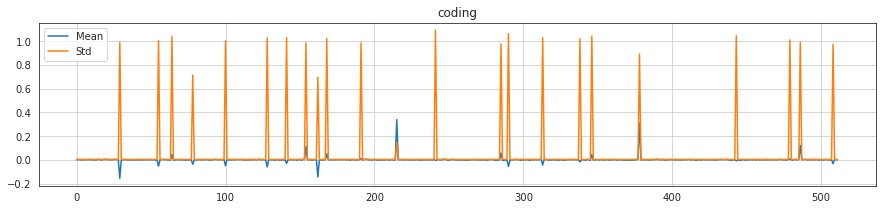

In [4]:
coding_mean = coding.mean()
coding_std = coding.std()
settings = dict(title='coding', figsize=(15,3), grid=True)
df = pd.DataFrame({'Mean':coding_mean,'Std':coding_std} )
df.plot(**settings);


             Mean         Std
count  512.000000  512.000000
mean     0.000881    0.045462
std      0.024738    0.200347
min     -0.156705    0.002014
25%     -0.001435    0.002905
50%      0.000064    0.003004
75%      0.001505    0.003116
max      0.338374    1.094318


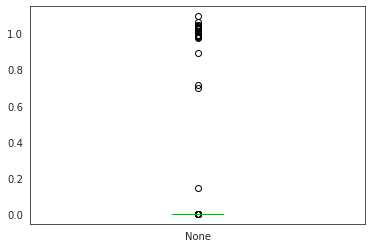

In [5]:
# coding_std.plot.hist(bins=50 );
print(df.describe())
coding_std.plot.box();

In [6]:
# Define sig dimensions :  std of coding > mean of std
sig_dim = df.query(f'Std > Std.mean()').index.values

print(f'Number of signuficant dimensions : {len(sig_dim)}')
print(f'Signuficant dimensions : {sig_dim}')


Number of signuficant dimensions : 23
Signuficant dimensions : ['29' '55' '64' '78' '100' '128' '141' '154' '162' '168' '191' '215' '241'
 '285' '290' '313' '338' '346' '378' '443' '479' '486' '508']


,29,55,64,78,100,128,141,154,162,168,...,285,290,313,338,346,378,443,479,486,508
0,1.440094,0.174224,-0.221595,-1.036199,1.021031,-1.426476,0.110341,-0.071215,0.411985,1.184063,...,1.197139,0.746766,0.052929,-0.310045,-0.693714,-0.313593,2.203695,-0.229061,0.001471,-0.317842
1,0.419128,-0.217435,-0.405216,-0.070783,-1.488462,-1.963904,0.147752,-1.131330,-0.793365,1.063388,...,-0.751556,-1.433011,0.098805,0.634349,-0.481576,0.148188,-0.405769,-0.475578,0.478149,0.386901
2,-0.705136,-1.228387,-1.160361,0.579542,-1.160797,-2.136880,0.149318,-0.935007,-0.224982,-0.426996,...,0.919567,-1.137041,1.263510,1.569428,0.617469,0.823239,-1.485464,0.306954,0.653162,0.917296
3,3.144733,0.730322,1.127994,-0.209262,1.995160,-1.360850,0.427535,2.020256,0.784087,0.735593,...,-0.497171,-0.717720,0.554548,-0.644555,1.401307,-0.316081,-0.615431,-1.163351,0.335267,-0.266727
4,0.927996,-0.650796,1.861692,0.178576,1.141685,1.508621,-0.029309,0.320633,-1.061709,-0.018586,...,-0.574507,-2.623826,1.535585,-0.549596,-0.176952,0.252950,-0.168059,-1.371850,-2.349429,1.142986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,0.722014,1.618732,0.381254,0.219350,0.450828,-0.741699,-0.338352,-0.708014,-0.538409,-0.721692,...,1.299159,2.068264,-0.986057,1.359322,1.475134,1.506065,-0.112067,0.210591,0.889665,0.103783
8871,-0.332031,-2.205485,0.043687,0.013502,-0.222580,1.518124,0.227662,-0.442974,-0.346438,1.240175,...,-0.145387,0.076838,0.487404,1.126754,0.602080,-0.157528,0.539151,2.523095,1.697144,1.017337
8872,-0.013714,-0.432479,1.139718,-0.404173,-1.797816,-1.522282,0.164255,1.214369,-0.490399,-1.751749,...,0.210453,-0.922181,0.086821,-0.574948,1.459546,0.783827,-0.973091,-0.980054,-1.345229,0.326988
8873,-0.232476,0.379771,1.775021,1.431992,-0.027900,0.992502,1.346964,0.588216,0.647001,1.201320,...,0.548235,-0.998878,1.122749,-0.984214,-0.194756,1.716188,0.582597,-0.077605,0.562717,-0.566896


- 產出特徵的內差值
    - 針對顯著變化的維度計算其內差值
        - 0 +- 2*std 
        - z_base =  torch.zeros((1,512)。 
            - ~~基質採用各維度的均值(接近0)~~


In [8]:
dir_save = Path(f"./results/latent")
dir_save.mkdir(parents=True, exist_ok=True)

def im_convert(tensor, f_name=None, figsize:tuple=(16, 4),save=False):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)              # (c,w,h) > (w,h,c)
#     image = image*std + mean                      # unnormalize
    image = image.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(f'{f_name}')
    plt.axis('off')
    plt.imshow(image)
    
    if save:
        plt.savefig(dir_save.joinpath(f_name + '.jpg'),
                    bbox_inches='tight',
                   )
        print(f'{f_name} Saved', end='\r')
    plt.close()

In [15]:
num = 30
c = 3

for dim in sig_dim:
    print(dim, end='\r')
    # 產出該維度特徵內插值
    # z_base = torch.Tensor(df.Mean).reshape(1,512)
    z_base = torch.zeros((1,512)).to(device)
    mean, std, *_ = df.loc[dim]
    interplot_ = np.linspace(mean - c*std,  mean + c*std, num)
    z_interplot = []
    for l in interplot_:
        z_base[0][int(dim)] = l
        z_interplot.append(z_base.clone())
        
    # 將該維度內插值送入decoder產生圖像
    imgs_rec = []
    with torch.no_grad():
        for idx, z in enumerate(z_interplot):
            print(idx, end='\r')
            img_rec = model.decoder(z) 
            imgs_rec.extend(img_rec)
    im_convert(make_grid(imgs_rec, nrow=10, padding=2, pad_value=255),
               f_name=f'Dimensions_{dim}', save=True)
    
# imgs_rec_all = torch.stack(imgs_rec)
# im_convert(make_grid(imgs_rec_all, nrow=num, padding=2, pad_value=255), 
#            f_name='Dimensions_All_Sig', figsize:tuple=(16, 12), save=True)


- 潛在空間(z)各維度內差圖
    - ~~row(每行): 各維度~~
    - cols(每列): 各維度內插值(由左上至右下: - 0 +)  
    
<!-- ![潛在空間(z)各維度內差圖](imgs_jupyter/latent_interplot.JPG) -->

![Dimensions_479](imgs_jupyter/Dimensions_479.jpg)
![Dimensions_168](imgs_jupyter/Dimensions_168.jpg)




##### 降維分群探索
- 類群、海拔、地點?  很可能是反映類群

- 檢視維度空間多樣性
    - 地區
    - 海拔
    - 地區x海拔


#### 檢視氣候變異與型態多樣性間的關聯- 找出關鍵特徵


##### 檢視在不同海拔/溫度下的表徵多樣性
##### 耐溫能力(耐溫範圍、耐溫上、下界)與型態的關係
##### 建立下游任務: eg: 海拔、耐溫範圍預測
- 檢視對應之下游任務中，模型主要反映的區域
        - 特徵圖(feature map)中，對於類別目標改變而有較大反應的像素位置(即gradcam之概念)
